# Modeling
ML Tasks

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Input

In [2]:
from sklearn.datasets import load_files

corpus = load_files("../data/")

doc_count = len(corpus.data)
print("Doc count:", doc_count)
assert doc_count is 56, "Wrong number of documents loaded, should be 56 (56 stories)"

Doc count: 56


## Vectorizer

In [3]:
from helpers.tokenizer import TextWrangler
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="lemma"))
X_bow = bow.fit_transform(corpus.data)

[nltk_data] Downloading package punkt to ../nltk/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../nltk/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ../nltk/...
[nltk_data]   Package wordnet is already up-to-date!


Decided for BOW vectors, containing lemmatized words. BOW results (in this case) in better cluster performance than with tf-idf vectors. Lemmatization worked slightly better than stemming. (-> KElbow plots in `plots/` dir).

## Models

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_jobs=-1, random_state=23)

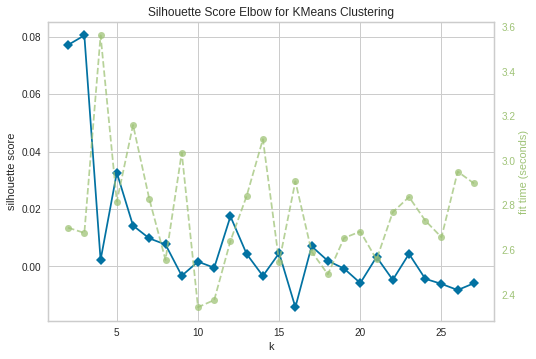

In [5]:
from yellowbrick.cluster import KElbowVisualizer

viz = KElbowVisualizer(kmeans, k=(2, 28), metric="silhouette")
viz.fit(X_bow)
#viz.poof(outpath="plots/KElbow_bow_lemma_silhoutte.png")
viz.poof()

In [6]:
from yellowbrick.cluster import SilhouetteVisualizer

def plot_silhoutte_plots(max_n):
    for i in range(2, max_n + 1):
        plt.clf()
        n_cluster = i

        viz = SilhouetteVisualizer(KMeans(n_clusters=n_cluster, random_state=23))

        viz.fit(X_bow)
        path = "plots/SilhouetteViz" + str(n_cluster)
        viz.poof(outpath=path)

#plot_silhoutte_plots(28)

Decided for 3 clusters, because of highest avg Silhoutte score compared to other cluster sizes. 

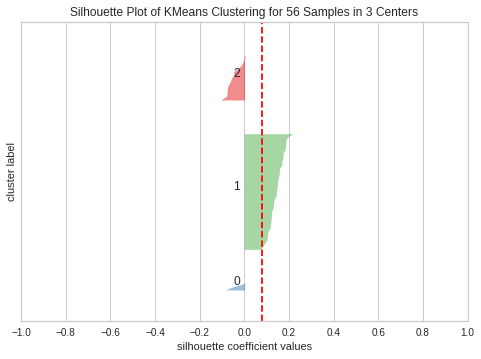

In [7]:
from yellowbrick.cluster import SilhouetteVisualizer

n_clusters = 3
model = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=23)

viz = SilhouetteVisualizer(model)

viz.fit(X_bow)
viz.poof()

Nonetheless, the assignment isn't perfect. Cluster \#1 looks good, but the many negative vals in cluster \#0 & \#1 suggest that there exist a cluster with more similar docs than in the actual assigned cluster. As a cluster size of 2 also leads to an inhomogen cluster and has a lower avg Silhoutte score, we go with the size of 3. Nevertheless, in general those findings suggest that the Sherlock Holmes stories should be represented in a single collection only.

## Training

In [8]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("bow", bow),
                 ("kmeans", model)])
pipe.fit(corpus.data)

pred = pipe.predict(corpus.data)

## Evaluation

### Cluster density
Silhoutte coefficient: [-1,1], where 1 is most dense and negative vals correspond to ill seperation.

In [9]:
from sklearn.metrics import silhouette_score

print("Avg Silhoutte score:", silhouette_score(X_bow, pred), "(novel collections)")

Avg Silhoutte score: 0.08043954719290361 (novel collections)


Compared to original collections by Sir Arthur Conan Doyle:

In [10]:
print("AVG Silhoutte score", silhouette_score(X_bow, corpus.target), "(original collections)")

AVG Silhoutte score -0.01820726730325904 (original collections)


Average Silhoutte coefficient is at least slightly positive and much better than the score of the original assignment (which is even negative). Success.

### Visual Inspection

We come from the original assignment by Sir Arthur Conan Doyle...

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

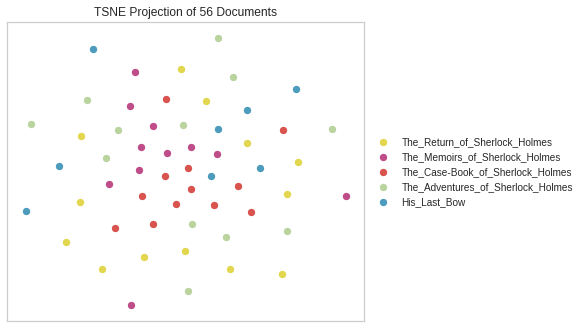

In [11]:
from yellowbrick.text import TSNEVisualizer

# Map target names of original collections to target vals
collections_map = {}
for i, collection_name in enumerate(corpus.target_names):
    collections_map[i] = collection_name

# Plot
tsne_original = TSNEVisualizer()
labels = [collections_map[c] for c in corpus.target]
tsne_original.fit(X_bow, labels)
tsne_original.poof()

... to the novel collection assignment:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


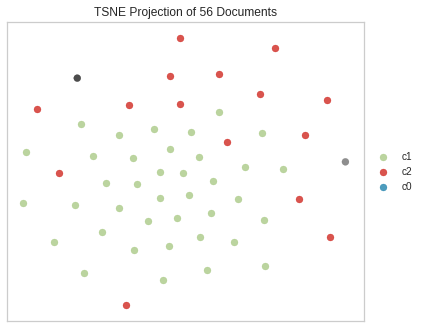

In [12]:
# Plot
tsne_novel = TSNEVisualizer()
labels = ["c{}".format(c) for c in pipe.named_steps.kmeans.labels_]
tsne_novel.fit(X_bow, labels)
tsne_novel.poof()

Confirms the findings from the Silhoutte plot above (in the `Models` section), cluster \#1 looks very coherent, cluster \#2 is seperated and the two documents of cluster \#0 fly somewhere around.
Nonetheless, compared to the original collection, this looks far better. Success.

# Document-Cluster Assignment

Finally, we want to assign the Sherlock Holmes stories to the novel collection created by clustering, right?

Create artificial titles for the collections created from clusters.

In [13]:
# Novel titles, can be more creative ;>
novel_collections_map = {0: "The Unassignable Adventures of Cluster 0", 
                         1: "The Adventures of Sherlock Holmes in Cluster 1",
                         2: "The Case-Book of Cluster 2"}

Let's see how the the books are differently assigned to collections by Sir Arthur Conan Doyle (_Original Collection_), respectively by the clustering algo (_Novel Collection_).

In [14]:
orig_assignment = [collections_map[c] for c in corpus.target]
novel_assignment = [novel_collections_map[p] for p in pred]

titles = [" ".join(f_name.split("/")[-1].split(".")[0].split("_")) 
          for f_name in corpus.filenames]

# Final df, compares original with new assignment
df_documents = pd.DataFrame([orig_assignment, novel_assignment], 
                            columns=titles, index=["Original Collection", "Novel Collection"]).T
df_documents.to_csv("collections.csv")
df_documents

,Original Collection,Novel Collection
THE ADVENTURE OF THE ABBEY GRANGE,The_Return_of_Sherlock_Holmes,The Adventures of Sherlock Holmes in Cluster 1
THE CROOKED MAN,The_Memoirs_of_Sherlock_Holmes,The Adventures of Sherlock Holmes in Cluster 1
THE RESIDENT PATIENT,The_Memoirs_of_Sherlock_Holmes,The Adventures of Sherlock Holmes in Cluster 1
THE ADVENTURE OF THE THREE GABLES,The_Case-Book_of_Sherlock_Holmes,The Adventures of Sherlock Holmes in Cluster 1
THE ADVENTURE OF THE BLUE CARBUNCLE,The_Adventures_of_Sherlock_Holmes,The Adventures of Sherlock Holmes in Cluster 1
THE ADVENTURE OF THE CARDBOARD BOX,His_Last_Bow,The Adventures of Sherlock Holmes in Cluster 1
SILVER BLAZE,The_Memoirs_of_Sherlock_Holmes,The Case-Book of Cluster 2
THE ADVENTURE OF BLACK PETER,The_Return_of_Sherlock_Holmes,The Adventures of Sherlock Holmes in Cluster 1
THE ADVENTURE OF THE DANCING MEN,The_Return_of_Sherlock_Holmes,The Case-Book of Cluster 2
THE ILLUSTRIOUS CLIENT,The_Case-Book_of_Sherlock_Holmes,The Adventures of Sherlock Holmes in Cluster 1


In [15]:
df_documents["Novel Collection"].value_counts()

The Adventures of Sherlock Holmes in Cluster 1    38
The Case-Book of Cluster 2                        15
The Unassignable Adventures of Cluster 0           3
Name: Novel Collection, dtype: int64

Collections are uneven assigned. Cluster \#1 is the predominant one. Looks like cluster \#0 subsume the (rational) unassignable stories.

T-SNE plot eventually looks like that:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


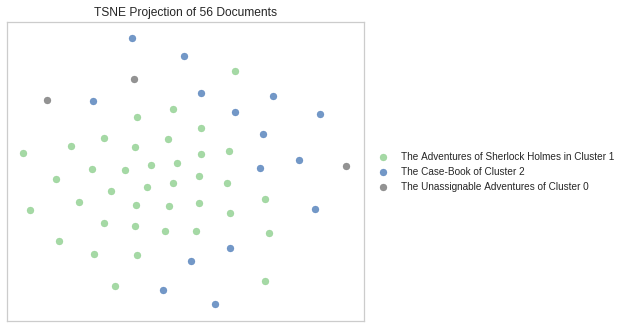

In [16]:
tsne_novel_named = TSNEVisualizer(colormap="Accent")
tsne_novel_named.fit(X_bow, novel_assignment)
tsne_novel_named.poof(outpath="plots/Novel_Sherlock_Holmes_Collections.png")

# Conclusion

A more rational assignment of Sherlock Holmes stories to collections is possible. And this can be achieved by using NLP and clustering, as shown above.

Nonetheless, the results (and also taken those from the HolmesTopicModels into account) suggest that there doesn't exist a perfect solution to seperate the stories. So we'd prefer to treat the whole canon as a single compilation of Sherlock Holmes stories.

But, if seperate collections from the canon should be derived, the most promising solution is the one presented above, by using the clustering approach.